<a href="https://colab.research.google.com/github/SuhwanChung/CE7454/blob/chunhung/StemGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# choose your runtime (GPU/None)


from google.colab import drive
import os
import glob
import re
import cv2
from functools import partial
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import seaborn as sns
sns.set_style('whitegrid')
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torchvision.transforms as T
from datetime import datetime
import json
import time


drive.mount('/content/drive')
wd = 'drive/MyDrive/CE7454 Demand forecast' #specify your project folder name

if not os.path.exists(os.path.join(wd,'StemGNN')):
  !git clone https://github.com/microsoft/StemGNN.git '{wd}/StemGNN'


!pip install --upgrade pip
!pip install -r '{wd}/StemGNN/requirements.txt'
!pip install torch==1.7.1 torchvision==0.8.2 


# restart to update torch version
#os.kill(os.getpid(), 9)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
import os
import glob
import re
import cv2
from functools import partial
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import seaborn as sns
sns.set_style('whitegrid')
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torchvision.transforms as T
from datetime import datetime
import json
import time


print(torch.__version__)
wd = 'drive/MyDrive/CE7454 Demand forecast'
%cd '{wd}/StemGNN'

1.7.1
/content/drive/MyDrive/CE7454 Demand forecast/StemGNN


In [3]:
'''
!pip install yahoofinancials
import pandas as pd
from yahoofinancials import YahooFinancials
from shutil import copyfile
from tqdm import tqdm


def main(in_ticker_csv, out_csv):
    output_file_path = out_csv
    temp_file_path = output_file_path + '.temp'
    date_error_msg = 'Dates are not aligned when adding new company stock prices!\n' + \
                 'Date in file: {}, Date to add: {}'

    # Read company symbols
    sp_df = pd.read_csv(in_ticker_csv, encoding = 'unicode_escape')
    sp_500_symbols = sp_df.Ticker.values.tolist()

    # Prepare the file to write stock prices
    symbol_subset = sp_500_symbols[:4]
    history = YahooFinancials(symbol_subset)
    data = history.get_historical_price_data(start_date='2016-09-30',
                                                  end_date='2021-09-30',
                                                  time_interval='daily')
    prices_df = pd.DataFrame({
        a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in symbol_subset
    })
    with open(output_file_path, 'w') as wf:
        wf.write(','.join(['date']) + '\n')
        for index, row in prices_df.iterrows():
            wf.write(','.join([index]) + '\n')
    date_count = len(prices_df.index)

    # Write stock prices of a sebset of companies at a time, or it may hang
    batch_size = 1
    for i in tqdm(range(0, len(sp_500_symbols), batch_size)):
        # Query a subset of companies only
        symbol_subset = sp_500_symbols[i:i+batch_size]
        history = YahooFinancials(symbol_subset)
        data = history.get_historical_price_data(start_date='2016-09-30',
                                                      end_date='2021-09-30',
                                                      time_interval='daily')
        try:
            prices_df = pd.DataFrame({
                a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in symbol_subset
            })
        except:
            print('Skipping for symbols {} as their yahoo queries are not responding'.format(symbol_subset))
            continue

        new_data_to_add = list(prices_df.iterrows())
        if len(new_data_to_add) != date_count:
            print('Skipping for symbols {} as they don\'t have the price info for all the dates'.format(symbol_subset))
            continue
        
        copyfile(output_file_path, temp_file_path)
        with open(temp_file_path, 'r') as rf, open(output_file_path, 'w') as wf:
            for i2, line in enumerate(rf.readlines()):
                # Add more company symbols to the file
                if i2 == 0:
                    wf.write(line[:-1] + ',' + ','.join(symbol_subset) + '\n')
                # For each new company, add their stock prices
                else:
                    assert line[:-1].split(',')[0] == new_data_to_add[i2-1][0], date_error_msg.format(line[:-1].split(',')[0], new_data_to_add[i2-1][0])
                    wf.write(line[:-1] + ',' + ','.join([str(t) for t in new_data_to_add[i2-1][1].values.tolist()]) + '\n')

    print('Done writing all company stock prices to file.')
    '''


"\n!pip install yahoofinancials\nimport pandas as pd\nfrom yahoofinancials import YahooFinancials\nfrom shutil import copyfile\nfrom tqdm import tqdm\n\n\ndef main(in_ticker_csv, out_csv):\n    output_file_path = out_csv\n    temp_file_path = output_file_path + '.temp'\n    date_error_msg = 'Dates are not aligned when adding new company stock prices!\n' +                  'Date in file: {}, Date to add: {}'\n\n    # Read company symbols\n    sp_df = pd.read_csv(in_ticker_csv, encoding = 'unicode_escape')\n    sp_500_symbols = sp_df.Ticker.values.tolist()\n\n    # Prepare the file to write stock prices\n    symbol_subset = sp_500_symbols[:4]\n    history = YahooFinancials(symbol_subset)\n    data = history.get_historical_price_data(start_date='2016-09-30',\n                                                  end_date='2021-09-30',\n                                                  time_interval='daily')\n    prices_df = pd.DataFrame({\n        a: {x['formatted_date']: x['adjclose'] for x 

In [4]:
#main('/content/drive/My Drive/dataset/sp500/S&P 500 tickers.csv', '/content/drive/My Drive/dataset/sp500/sp500_prices_adjclose_30_09_16_30_09_21.csv')

In [5]:
# config args
'''
args ={


'train':True,
'evaluate':True,
'dataset':'sp500_prices_adjclose_30_09_16_30_09_21',
'window_size':12,
'horizon':3,
'train_length': 7,
'valid_length': 2,
'test_length' :1,
'epoch':50,
'lr' :1e-4,
'multi_layer':5,
'device':'cuda',
'validate_freq':1,
'batch_size':32,
'norm_method':'z_score',
'optimizer':'RMSProp',
'early_stop':False,
'exponential_decay_step':5,
'decay_rate' :0.5,
'dropout_rate' :0.5,
'leakyrelu_rate':0.2,
}

class AttrDict(dict):
  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)
    self.__dict__ = self

args = AttrDict(args)
'''

"\nargs ={\n\n\n'train':True,\n'evaluate':True,\n'dataset':'sp500_prices_adjclose_30_09_16_30_09_21',\n'window_size':12,\n'horizon':3,\n'train_length': 7,\n'valid_length': 2,\n'test_length' :1,\n'epoch':50,\n'lr' :1e-4,\n'multi_layer':5,\n'device':'cuda',\n'validate_freq':1,\n'batch_size':32,\n'norm_method':'z_score',\n'optimizer':'RMSProp',\n'early_stop':False,\n'exponential_decay_step':5,\n'decay_rate' :0.5,\n'dropout_rate' :0.5,\n'leakyrelu_rate':0.2,\n}\n\nclass AttrDict(dict):\n  def __init__(self,*args, **kwargs):\n    super().__init__(*args, **kwargs)\n    self.__dict__ = self\n\nargs = AttrDict(args)\n"

In [6]:
# config args

args ={
'train':True,
'evaluate':True,
'dataset':'sp500_prices_adjclose_30_09_16_30_09_21',
#'data_dir': proj_dir + 'data/',
'window_size':12,
'horizon':3,
'train_length': 7,
'valid_length': 2,
'test_length' :1,
'epoch':50,
'lr' :1e-4,
'multi_layer':5,
'device':'cuda',
'validate_freq':1,
'batch_size':8,
'norm_method':'z_score',
'optimizer':'RMSProp',
'early_stop':False,
'exponential_decay_step':5,
'decay_rate' :0.5,
'dropout_rate' :0.5,
'leakyrelu_rate':0.2,
}

class AttrDict(dict):
  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)
    self.__dict__ = self
args = AttrDict(args)

In [7]:

# GET training data


print(f'Training configs: {args}')
#data_file = os.path.join('dataset', args.dataset + '.csv')
data_file = '/content/drive/My Drive/dataset/sp500/data.csv'

result_train_file = os.path.join('output', args.dataset, 'train')
result_test_file = os.path.join('output', args.dataset, 'test')
if not os.path.exists(result_train_file):
    os.makedirs(result_train_file)
if not os.path.exists(result_test_file):
    os.makedirs(result_test_file)
# data = pd.read_csv(data_file).values
data = pd.read_csv(data_file).drop('date',1).values
# split data
train_ratio = args.train_length / (args.train_length + args.valid_length + args.test_length)
valid_ratio = args.valid_length / (args.train_length + args.valid_length + args.test_length)
test_ratio = 1 - train_ratio - valid_ratio
train_data = data[:int(train_ratio * len(data))]
valid_data = data[int(train_ratio * len(data)):int((train_ratio + valid_ratio) * len(data))]
test_data = data[int((train_ratio + valid_ratio) * len(data)):]


Training configs: {'train': True, 'evaluate': True, 'dataset': 'sp500_prices_adjclose_30_09_16_30_09_21', 'window_size': 12, 'horizon': 3, 'train_length': 7, 'valid_length': 2, 'test_length': 1, 'epoch': 50, 'lr': 0.0001, 'multi_layer': 5, 'device': 'cuda', 'validate_freq': 1, 'batch_size': 8, 'norm_method': 'z_score', 'optimizer': 'RMSProp', 'early_stop': False, 'exponential_decay_step': 5, 'decay_rate': 0.5, 'dropout_rate': 0.5, 'leakyrelu_rate': 0.2}


In [8]:
train_data.shape , valid_data.shape , test_data.shape

((871, 493), (249, 493), (125, 493))

In [9]:
pd.read_csv(data_file).drop('date',1).head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,...,UNM,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VIAC,VTRS,V,VNO,VMC,WRB,WAB,WMT,WBA,DIS,WM,WAT,WEC,WFC,WELL,WST,WDC,WU,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,151.891006,38.611118,50.265553,128.580002,112.105362,42.963554,108.540001,6.91,146.193253,10.761644,31.922256,45.220772,123.472305,52.990002,61.645340,79.692589,95.169441,93.750000,65.677902,32.932114,62.508064,804.059998,777.289978,47.520481,837.309998,9.51981,42.706928,35.288368,54.155262,59.305332,52.002068,103.212494,68.355148,88.066017,74.000618,46.267582,144.636215,31.016325,58.256134,92.610001,...,29.629341,42.178417,55.373524,78.239998,79.937149,41.633564,87.209999,46.460678,50.095135,37.567600,80.039871,64.433357,108.580971,34.721607,79.214218,64.965401,69.385086,88.244537,57.728222,158.490005,51.358322,37.978359,59.052296,72.783386,52.013783,17.428846,41.255169,26.899380,139.531525,23.011034,123.988655,89.726730,35.787510,50.331238,49.347263,59.752254,69.610001,125.281212,27.626471,50.397995
1,150.865356,38.848495,50.393078,127.800003,110.903267,42.769588,108.449997,6.95,144.056061,10.443401,31.789005,45.268795,124.799675,53.709999,62.796619,79.077354,93.017029,90.209999,64.972633,32.493702,61.803303,800.380005,772.559998,47.234901,836.739990,9.51981,42.229328,36.339024,53.564888,59.092339,51.633999,102.228912,67.642738,89.001686,73.395988,45.928669,145.095734,30.767885,58.075367,91.870003,...,29.453123,42.098831,54.244583,78.830002,79.887985,41.553467,86.790001,46.402641,50.269009,37.646442,80.194717,63.319260,105.688133,34.529243,78.738838,64.866287,69.178513,87.892921,57.456604,159.050003,50.629280,37.592400,58.278305,72.763847,52.360722,17.253054,41.025394,26.781473,139.454086,22.936153,123.372269,91.439835,35.300369,49.951485,49.366081,59.824631,69.919998,125.146309,27.706623,50.737137
2,147.969437,38.437649,50.209766,127.370003,108.499123,42.798687,108.389999,6.97,143.663879,10.007910,31.757912,44.971085,121.914253,54.639999,64.312950,77.017220,92.334579,89.459999,64.219681,31.745831,61.297310,802.789978,776.429993,46.430740,834.030029,9.51981,41.143837,36.271553,52.443146,59.184952,51.774216,100.735313,65.679054,89.178215,73.771591,45.638168,145.277786,30.720116,58.066330,91.739998,...,29.914646,42.695702,53.421379,78.040001,79.317566,41.056873,86.419998,46.576717,50.836399,37.419777,80.068909,62.663521,105.821800,34.607395,78.942566,64.632088,69.058044,87.987953,56.723221,158.199997,49.256981,37.523777,56.769817,71.562187,52.209488,17.018656,40.736069,26.132990,139.626190,22.621653,122.867989,88.768867,34.439171,49.145657,49.168491,59.403515,69.410004,124.519951,27.964897,50.688683
3,148.581345,39.021973,50.520592,127.449997,108.471596,43.186615,108.800003,6.78,146.006973,9.932537,31.935579,45.278381,121.612411,55.980000,63.938557,77.781601,90.505913,89.480003,64.381706,31.616882,61.270210,801.229980,776.469971,46.009869,844.359985,9.51981,41.430401,36.502880,52.443146,59.901596,52.492817,97.848305,65.003166,91.084839,73.313553,46.596817,145.009064,31.006773,58.464035,92.379997,...,30.552372,43.610882,52.864742,77.849998,78.973335,40.723114,87.650002,45.349922,51.623428,37.478905,80.668961,61.199276,104.399269,34.631435,79.146324,64.560013,69.290421,87.854912,56.505932,158.270004,49.145473,38.587318,55.585148,72.265602,52.698761,16.993544,39.604282,25.804541,141.200806,22.861273,123.232193,90.205650,34.369579,49.469841,48.876835,58.311253,70.000000,125.791908,28.338949,50.562714
4,147.934937,39.231968,50.074276,128.500000,108.756042,42.662914,108.559998,6.96,145.791321,9.765041,32.011089,45.422432,122.425407,54.860001,64.668640,77.968048,91.022133,89.440002,64.762932,31.539524,61.234070,803.080017,776.859985,46.430740,841.659973,9.51981,41.326202,36.792053,52.502171,57.649227,52.536633,98.822792,65.030571,90.749435,73.414307,46.664612,144.714203,31.302975,58.518276,92.1100

In [10]:
debug_step = 0
debug_corr_1 = None
debug_corr_2 = None
debug_corr_3 = None
debug_corr_4 = None

In [11]:
import math
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
    
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerModel(nn.Module):

    def __init__(self, input_size, d_model, d_out, nhead, d_hid, nlayers, dropout=0.5):
        super().__init__()

        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(input_size, d_model, bias=False)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, d_out)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)


        return output

In [12]:
# move training dependencies here for the ease of training


from utils.math_utils import evaluate



class GLU(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(GLU, self).__init__()
        self.linear_left = nn.Linear(input_channel, output_channel)
        self.linear_right = nn.Linear(input_channel, output_channel)

    def forward(self, x):
        return torch.mul(self.linear_left(x), torch.sigmoid(self.linear_right(x)))


class StockBlockLayer(nn.Module):
    def __init__(self, time_step, unit, multi_layer, stack_cnt=0):
        super(StockBlockLayer, self).__init__()
        self.time_step = time_step
        self.unit = unit
        self.stack_cnt = stack_cnt
        self.multi = multi_layer
        self.weight = nn.Parameter(
            torch.Tensor(1, 3 + 1, 1, self.time_step * self.multi,
                         self.multi * self.time_step))  # [K+1, 1, in_c, out_c]
        nn.init.xavier_normal_(self.weight)
        self.forecast = nn.Linear(self.time_step * self.multi, self.time_step * self.multi)
        self.forecast_result = nn.Linear(self.time_step * self.multi, self.time_step)
        if self.stack_cnt == 0:
            self.backcast = nn.Linear(self.time_step * self.multi, self.time_step)
        self.backcast_short_cut = nn.Linear(self.time_step, self.time_step)
        self.relu = nn.ReLU()
        self.GLUs = nn.ModuleList()
        self.output_channel = 4 * self.multi
        for i in range(3):
            if i == 0:
                self.GLUs.append(GLU(self.time_step * 4, self.time_step * self.output_channel))
                self.GLUs.append(GLU(self.time_step * 4, self.time_step * self.output_channel))
            elif i == 1:
                self.GLUs.append(GLU(self.time_step * self.output_channel, self.time_step * self.output_channel))
                self.GLUs.append(GLU(self.time_step * self.output_channel, self.time_step * self.output_channel))
            else:
                self.GLUs.append(GLU(self.time_step * self.output_channel, self.time_step * self.output_channel))
                self.GLUs.append(GLU(self.time_step * self.output_channel, self.time_step * self.output_channel))

    def spe_seq_cell(self, input):
        batch_size, k, input_channel, node_cnt, time_step = input.size()
        input = input.view(batch_size, -1, node_cnt, time_step)
        ffted = torch.rfft(input, 1, onesided=False)
        real = ffted[..., 0].permute(0, 2, 1, 3).contiguous().reshape(batch_size, node_cnt, -1)
        img = ffted[..., 1].permute(0, 2, 1, 3).contiguous().reshape(batch_size, node_cnt, -1)
        for i in range(3):
            real = self.GLUs[i * 2](real)
            img = self.GLUs[2 * i + 1](img)
        real = real.reshape(batch_size, node_cnt, 4, -1).permute(0, 2, 1, 3).contiguous()
        img = img.reshape(batch_size, node_cnt, 4, -1).permute(0, 2, 1, 3).contiguous()
        time_step_as_inner = torch.cat([real.unsqueeze(-1), img.unsqueeze(-1)], dim=-1)
        iffted = torch.irfft(time_step_as_inner, 1, onesided=False)
        return iffted

    def forward(self, x, mul_L):
        mul_L = mul_L.unsqueeze(1)
        x = x.unsqueeze(1)
        gfted = torch.matmul(mul_L, x)
        gconv_input = self.spe_seq_cell(gfted).unsqueeze(2)
        igfted = torch.matmul(gconv_input, self.weight)
        igfted = torch.sum(igfted, dim=1)
        forecast_source = torch.sigmoid(self.forecast(igfted).squeeze(1))
        forecast = self.forecast_result(forecast_source)
        if self.stack_cnt == 0:
            backcast_short = self.backcast_short_cut(x).squeeze(1)
            backcast_source = torch.sigmoid(self.backcast(igfted) - backcast_short)
        else:
            backcast_source = None
        return forecast, backcast_source


class Model(nn.Module):
    def __init__(self, units, stack_cnt, time_step, multi_layer, horizon=1, dropout_rate=0.5, leaky_rate=0.2,
                 device='cpu'):
        super(Model, self).__init__()
        self.unit = units
        self.stack_cnt = stack_cnt
        self.unit = units
        self.alpha = leaky_rate
        self.correlation_time_step = 4
        self.time_step = time_step
        self.horizon = horizon
        self.weight_key = nn.Parameter(torch.zeros(size=(self.unit, 1)))
        nn.init.xavier_uniform_(self.weight_key.data, gain=1.414)
        self.weight_query = nn.Parameter(torch.zeros(size=(self.unit, 1)))
        nn.init.xavier_uniform_(self.weight_query.data, gain=1.414)
        #self.GRU = nn.GRU(self.time_step, self.unit)

        self.transformer = TransformerModel(input_size=self.correlation_time_step, d_model=16, d_out=self.unit, nhead=1, d_hid=8, nlayers=8)
        
        self.multi_layer = multi_layer
        self.stock_block = nn.ModuleList()
        self.stock_block.extend(
            [StockBlockLayer(self.time_step, self.unit, self.multi_layer, stack_cnt=i) for i in range(self.stack_cnt)])
        self.fc = nn.Sequential(
            nn.Linear(int(self.time_step), int(self.time_step)),
            nn.LeakyReLU(),
            nn.Linear(int(self.time_step), self.horizon),
        )
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.to(device)

    def get_laplacian(self, graph, normalize):
        """
        return the laplacian of the graph.
        :param graph: the graph structure without self loop, [N, N].
        :param normalize: whether to used the normalized laplacian.
        :return: graph laplacian.
        """
        if normalize:
            D = torch.diag(torch.sum(graph, dim=-1) ** (-1 / 2))
            L = torch.eye(graph.size(0), device=graph.device, dtype=graph.dtype) - torch.mm(torch.mm(D, graph), D)
        else:
            D = torch.diag(torch.sum(graph, dim=-1))
            L = D - graph
        return L

    def cheb_polynomial(self, laplacian):
        """
        Compute the Chebyshev Polynomial, according to the graph laplacian.
        :param laplacian: the graph laplacian, [N, N].
        :return: the multi order Chebyshev laplacian, [K, N, N].
        """
        N = laplacian.size(0)  # [N, N]
        laplacian = laplacian.unsqueeze(0)
        first_laplacian = torch.zeros([1, N, N], device=laplacian.device, dtype=torch.float)
        second_laplacian = laplacian
        third_laplacian = (2 * torch.matmul(laplacian, second_laplacian)) - first_laplacian
        forth_laplacian = 2 * torch.matmul(laplacian, third_laplacian) - second_laplacian
        multi_order_laplacian = torch.cat([first_laplacian, second_laplacian, third_laplacian, forth_laplacian], dim=0)
        return multi_order_laplacian

    def latent_correlation_layer(self, x):
        global debug_step, debug_corr_3, debug_corr_4
        
        #input, _ = self.GRU(x.permute(2, 0, 1).contiguous())
        #print(x.shape)
        #print(x.permute(0, 2, 1).shape)
        
        input = self.transformer(x.permute(0, 2, 1).contiguous())
        #input = input.permute(1, 0, 2)
        #input = input.permute(1, 0, 2).contiguous()
        attention = self.self_graph_attention(input)
        attention = torch.mean(attention, dim=0)
        if debug_step == 49:
            debug_corr_3 = attention.cpu().detach().numpy()
        degree = torch.sum(attention, dim=1)
        # laplacian is sym or not
        attention = 0.5 * (attention + attention.T)
        if debug_step == 49:
            debug_corr_4 = attention.cpu().detach().numpy()
        degree_l = torch.diag(degree)
        diagonal_degree_hat = torch.diag(1 / (torch.sqrt(degree) + 1e-7))
        laplacian = torch.matmul(diagonal_degree_hat,
                                 torch.matmul(degree_l - attention, diagonal_degree_hat))
        mul_L = self.cheb_polynomial(laplacian)
        return mul_L, attention

    def self_graph_attention(self, input):
        global debug_step, debug_corr_1, debug_corr_2

        input = input.permute(0, 2, 1).contiguous()
        bat, N, fea = input.size()
        key = torch.matmul(input, self.weight_key)
        query = torch.matmul(input, self.weight_query)
        data = key.repeat(1, 1, N).view(bat, N * N, 1) + query.repeat(1, N, 1)
        data = data.squeeze(2)
        data = data.view(bat, N, -1)
        if debug_step == 49:
            debug_corr_1 = data.cpu().detach().numpy()
        data = self.leakyrelu(data)
        if debug_step == 49:
            debug_corr_2 = data.cpu().detach().numpy()
        debug_step += 1
        attention = F.softmax(data, dim=2)
        attention = self.dropout(attention)
        return attention

    def graph_fft(self, input, eigenvectors):
        return torch.matmul(eigenvectors, input)

    def forward(self, x):
        mul_L, attention = self.latent_correlation_layer(x[:,-4:,:])
        X = x.unsqueeze(1).permute(0, 1, 3, 2).contiguous()
        result = []
        for stack_i in range(self.stack_cnt):
            forecast, X = self.stock_block[stack_i](X, mul_L)
            result.append(forecast)
        forecast = result[0] + result[1]
        forecast = self.fc(forecast)
        if forecast.size()[-1] == 1:
            return forecast.unsqueeze(1).squeeze(-1), attention
        else:
            return forecast.permute(0, 2, 1).contiguous(), attention




def train(train_data, valid_data, args, result_file):
    node_cnt = train_data.shape[1]
    model = Model(node_cnt, 2, args.window_size, args.multi_layer, horizon=args.horizon)
    model.to(args.device)
    if len(train_data) == 0:
        raise Exception('Cannot organize enough training data')
    if len(valid_data) == 0:
        raise Exception('Cannot organize enough validation data')

    if args.norm_method == 'z_score':
        train_mean = np.mean(train_data, axis=0)
        train_std = np.std(train_data, axis=0)
        normalize_statistic = {"mean": train_mean.tolist(), "std": train_std.tolist()}
    elif args.norm_method == 'min_max':
        train_min = np.min(train_data, axis=0)
        train_max = np.max(train_data, axis=0)
        normalize_statistic = {"min": train_min.tolist(), "max": train_max.tolist()}
    else:
        normalize_statistic = None
    if normalize_statistic is not None:
        with open(os.path.join(result_file, 'norm_stat.json'), 'w') as f:
            json.dump(normalize_statistic, f)

    if args.optimizer == 'RMSProp':
        my_optim = torch.optim.RMSprop(params=model.parameters(), lr=args.lr, eps=1e-08)
    else:
        my_optim = torch.optim.Adam(params=model.parameters(), lr=args.lr, betas=(0.9, 0.999))
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=args.decay_rate)

    train_set = ForecastDataset(train_data, window_size=args.window_size, horizon=args.horizon,
                                normalize_method=args.norm_method, norm_statistic=normalize_statistic)
    valid_set = ForecastDataset(valid_data, window_size=args.window_size, horizon=args.horizon,
                                normalize_method=args.norm_method, norm_statistic=normalize_statistic)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, drop_last=False, shuffle=True,
                                         num_workers=0)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=args.batch_size, shuffle=False, num_workers=0)

    forecast_loss = nn.MSELoss(reduction='mean').to(args.device)

    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
    print(f"Total Trainable Params: {total_params}")

    best_validate_mae = np.inf
    best_performance = None
    validate_score_non_decrease_count = 0
    performance_metrics = {}

    training_losses = []

    for epoch in range(args.epoch):
        epoch_start_time = time.time()
        model.train()
        loss_total = 0
        cnt = 0
        for i, (inputs, target) in enumerate(train_loader):
            inputs = inputs.to(args.device)
            target = target.to(args.device)
            model.zero_grad()
            forecast, _ = model(inputs)
            loss = forecast_loss(forecast, target)
            cnt += 1
            loss.backward()
            my_optim.step()
            loss_total += float(loss)
        print('| end of epoch {:3d} | time: {:5.2f}s | train_total_loss {:5.4f}'.format(epoch, (
                time.time() - epoch_start_time), loss_total / cnt))
        training_losses.append(loss_total / cnt)
        save_model(model, result_file, epoch)
        if (epoch+1) % args.exponential_decay_step == 0:
            my_lr_scheduler.step()
        if (epoch + 1) % args.validate_freq == 0:
            is_best_for_now = False
            print('------ validate on data: VALIDATE ------')
            performance_metrics = \
                validate(model, valid_loader, args.device, args.norm_method, normalize_statistic,
                         node_cnt, args.window_size, args.horizon,
                         result_file=result_file)
            if best_validate_mae > performance_metrics['mae']:
                best_validate_mae = performance_metrics['mae']
                is_best_for_now = True
                validate_score_non_decrease_count = 0

                #added
                best_performance = performance_metrics
            else:
                validate_score_non_decrease_count += 1
            # save model
            if is_best_for_now:
                save_model(model, result_file)
        # early stop
        if args.early_stop and validate_score_non_decrease_count >= args.early_stop_step:
            break
    return performance_metrics, normalize_statistic, training_losses, best_performance 




def save_model(model, model_dir, epoch=None):
    if model_dir is None:
        return
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    epoch = str(epoch) if epoch else ''
    file_name = os.path.join(model_dir, epoch + '_stemgnn.pt')
    with open(file_name, 'wb') as f:
        torch.save(model, f)




def normalized(data, normalize_method, norm_statistic=None):
    if normalize_method == 'min_max':
        if not norm_statistic:
            norm_statistic = dict(max=np.max(data, axis=0), min=np.min(data, axis=0))
        scale = norm_statistic['max'] - norm_statistic['min'] + 1e-5
        data = (data - norm_statistic['min']) / scale
        data = np.clip(data, 0.0, 1.0)
    elif normalize_method == 'z_score':
        if not norm_statistic:
            norm_statistic = dict(mean=np.mean(data, axis=0), std=np.std(data, axis=0))
        mean = norm_statistic['mean']
        std = norm_statistic['std']
        std = [1 if i == 0 else i for i in std]
        data = (data - mean) / std
        norm_statistic['std'] = std
    return data, norm_statistic


def de_normalized(data, normalize_method, norm_statistic):
    if normalize_method == 'min_max':
        if not norm_statistic:
            norm_statistic = dict(max=np.max(data, axis=0), min=np.min(data, axis=0))
        scale = norm_statistic['max'] - norm_statistic['min'] + 1e-8
        data = data * scale + norm_statistic['min']
    elif normalize_method == 'z_score':
        if not norm_statistic:
            norm_statistic = dict(mean=np.mean(data, axis=0), std=np.std(data, axis=0))
        mean = norm_statistic['mean']
        std = norm_statistic['std']
        std = [1 if i == 0 else i for i in std]
        data = data * std + mean
    return data


class ForecastDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size, horizon, normalize_method=None, norm_statistic=None, interval=1):
        self.window_size = window_size
        self.interval = interval
        self.horizon = horizon
        self.normalize_method = normalize_method
        self.norm_statistic = norm_statistic
        df = pd.DataFrame(df)
        df = df.fillna(method='ffill', limit=len(df)).fillna(method='bfill', limit=len(df)).values
        self.data = df
        self.df_length = len(df)
        self.x_end_idx = self.get_x_end_idx()
        if normalize_method:
            self.data, _ = normalized(self.data, normalize_method, norm_statistic)

    def __getitem__(self, index):
        hi = self.x_end_idx[index]
        lo = hi - self.window_size
        train_data = self.data[lo: hi]
        target_data = self.data[hi:hi + self.horizon]
        x = torch.from_numpy(train_data).type(torch.float)
        y = torch.from_numpy(target_data).type(torch.float)
        return x, y

    def __len__(self):
        return len(self.x_end_idx)

    def get_x_end_idx(self):
        # each element `hi` in `x_index_set` is an upper bound for get training data
        # training data range: [lo, hi), lo = hi - window_size
        x_index_set = range(self.window_size, self.df_length - self.horizon + 1)
        x_end_idx = [x_index_set[j * self.interval] for j in range((len(x_index_set)) // self.interval)]
        return x_end_idx



def validate(model, dataloader, device, normalize_method, statistic,
             node_cnt, window_size, horizon,
             result_file=None):
    start = datetime.now()
    forecast_norm, target_norm = inference(model, dataloader, device,
                                           node_cnt, window_size, horizon)
    if normalize_method and statistic:
        forecast = de_normalized(forecast_norm, normalize_method, statistic)
        target = de_normalized(target_norm, normalize_method, statistic)
    else:
        forecast, target = forecast_norm, target_norm
    score = evaluate(target, forecast)
    score_by_node = evaluate(target, forecast, by_node=True)
    end = datetime.now()

    score_norm = evaluate(target_norm, forecast_norm)
    print(f'NORM: MAPE {score_norm[0]:7.9%}; MAE {score_norm[1]:7.9f}; RMSE {score_norm[2]:7.9f}.')
    print(f'RAW : MAPE {score[0]:7.9%}; MAE {score[1]:7.9f}; RMSE {score[2]:7.9f}.')
    if result_file:
        if not os.path.exists(result_file):
            os.makedirs(result_file)
        step_to_print = 0
        forcasting_2d = forecast[:, step_to_print, :]
        forcasting_2d_target = target[:, step_to_print, :]

        np.savetxt(f'{result_file}/target.csv', forcasting_2d_target, delimiter=",")
        np.savetxt(f'{result_file}/predict.csv', forcasting_2d, delimiter=",")
        np.savetxt(f'{result_file}/predict_abs_error.csv',
                   np.abs(forcasting_2d - forcasting_2d_target), delimiter=",")
        np.savetxt(f'{result_file}/predict_ape.csv',
                   np.abs((forcasting_2d - forcasting_2d_target) / forcasting_2d_target), delimiter=",")

    return dict(mae=score[1], mae_node=score_by_node[1], mape=score[0], mape_node=score_by_node[0],
                rmse=score[2], rmse_node=score_by_node[2], mae_norm=score_norm[1], mape_norm=score_norm[0], rmse_norm=score_norm[2])



def inference(model, dataloader, device, node_cnt, window_size, horizon):
    forecast_set = []
    target_set = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, target) in enumerate(dataloader):
            inputs = inputs.to(device)
            target = target.to(device)
            step = 0
            forecast_steps = np.zeros([inputs.size()[0], horizon, node_cnt], dtype=np.float)
            while step < horizon:
                forecast_result, a = model(inputs)
                len_model_output = forecast_result.size()[1]
                if len_model_output == 0:
                    raise Exception('Get blank inference result')
                inputs[:, :window_size - len_model_output, :] = inputs[:, len_model_output:window_size,
                                                                   :].clone()
                inputs[:, window_size - len_model_output:, :] = forecast_result.clone()
                forecast_steps[:, step:min(horizon - step, len_model_output) + step, :] = \
                    forecast_result[:, :min(horizon - step, len_model_output), :].detach().cpu().numpy()
                step += min(horizon - step, len_model_output)
            forecast_set.append(forecast_steps)
            target_set.append(target.detach().cpu().numpy())
    return np.concatenate(forecast_set, axis=0), np.concatenate(target_set, axis=0)

In [13]:

# def train(train_data, valid_data, args, result_file):
#     node_cnt = train_data.shape[1]
#     model = Model(node_cnt, 2, args.window_size, args.multi_layer, horizon=args.horizon)
#     model.to(args.device)
#     if len(train_data) == 0:
#         raise Exception('Cannot organize enough training data')
#     if len(valid_data) == 0:
#         raise Exception('Cannot organize enough validation data')

#     if args.norm_method == 'z_score':
#         train_mean = np.mean(train_data, axis=0)
#         train_std = np.std(train_data, axis=0)
#         normalize_statistic = {"mean": train_mean.tolist(), "std": train_std.tolist()}
#     elif args.norm_method == 'min_max':
#         train_min = np.min(train_data, axis=0)
#         train_max = np.max(train_data, axis=0)
#         normalize_statistic = {"min": train_min.tolist(), "max": train_max.tolist()}
#     else:
#         normalize_statistic = None
#     if normalize_statistic is not None:
#         with open(os.path.join(result_file, 'norm_stat.json'), 'w') as f:
#             json.dump(normalize_statistic, f)

#     if args.optimizer == 'RMSProp':
#         my_optim = torch.optim.RMSprop(params=model.parameters(), lr=args.lr, eps=1e-08)
#     else:
#         my_optim = torch.optim.Adam(params=model.parameters(), lr=args.lr, betas=(0.9, 0.999))
#     my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=args.decay_rate)

#     train_set = ForecastDataset(train_data, window_size=args.window_size, horizon=args.horizon,
#                                 normalize_method=args.norm_method, norm_statistic=normalize_statistic)
#     valid_set = ForecastDataset(valid_data, window_size=args.window_size, horizon=args.horizon,
#                                 normalize_method=args.norm_method, norm_statistic=normalize_statistic)
#     train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, drop_last=False, shuffle=True,
#                                          num_workers=0)
#     valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=args.batch_size, shuffle=False, num_workers=0)

#     forecast_loss = nn.MSELoss(reduction='mean').to(args.device)

#     total_params = 0
#     for name, parameter in model.named_parameters():
#         if not parameter.requires_grad: continue
#         param = parameter.numel()
#         total_params += param
#     print(f"Total Trainable Params: {total_params}")

#     return model, train_loader



# net, train_loader = train(train_data, valid_data, args, result_train_file)


In [14]:
# train_set = ForecastDataset(train_data, window_size=args.window_size, horizon=args.horizon,
#                                 normalize_method=args.norm_method, norm_statistic=None)
# for it, batch in enumerate(train_loader):
#   break

In [15]:
args

{'batch_size': 8,
 'dataset': 'sp500_prices_adjclose_30_09_16_30_09_21',
 'decay_rate': 0.5,
 'device': 'cuda',
 'dropout_rate': 0.5,
 'early_stop': False,
 'epoch': 50,
 'evaluate': True,
 'exponential_decay_step': 5,
 'horizon': 3,
 'leakyrelu_rate': 0.2,
 'lr': 0.0001,
 'multi_layer': 5,
 'norm_method': 'z_score',
 'optimizer': 'RMSProp',
 'test_length': 1,
 'train': True,
 'train_length': 7,
 'valid_length': 2,
 'validate_freq': 1,
 'window_size': 12}

In [16]:
# def latent_correlation_layer(self, x):
#       input, _ = self.GRU(x.permute(2, 0, 1).contiguous())
#       input = input.permute(1, 0, 2).contiguous()
#       attention = self.self_graph_attention(input)
#       attention = torch.mean(attention, dim=0)
#       degree = torch.sum(attention, dim=1)
#       # laplacian is sym or not
#       attention = 0.5 * (attention + attention.T)
#       degree_l = torch.diag(degree)
#       diagonal_degree_hat = torch.diag(1 / (torch.sqrt(degree) + 1e-7))
#       laplacian = torch.matmul(diagonal_degree_hat,
#                                 torch.matmul(degree_l - attention, diagonal_degree_hat))
#       mul_L = self.cheb_polynomial(laplacian)
#       return mul_L, attention


# def self_graph_attention( input, weights):
#     weight_key = weights[0]
#     weight_query = weights[1]
#     input = input.permute(0, 2, 1).contiguous()
#     bat, N, fea = input.size()
#     key = torch.matmul(input, weight_key)
#     query = torch.matmul(input, weight_query)
    
#     data = key.repeat(1, 1, N).view(bat, N * N, 1) + query.repeat(1, N, 1)
#     data = data.squeeze(2)
#     data = data.view(bat, N, -1)
#     # data = torch.nn.Leakyrelu(data)
#     import pdb; pdb.set_trace()
#     attention = F.softmax(data, dim=2)
#     attention = nn.functional.dropout(attention)
#     return attention

In [17]:
args

{'batch_size': 8,
 'dataset': 'sp500_prices_adjclose_30_09_16_30_09_21',
 'decay_rate': 0.5,
 'device': 'cuda',
 'dropout_rate': 0.5,
 'early_stop': False,
 'epoch': 50,
 'evaluate': True,
 'exponential_decay_step': 5,
 'horizon': 3,
 'leakyrelu_rate': 0.2,
 'lr': 0.0001,
 'multi_layer': 5,
 'norm_method': 'z_score',
 'optimizer': 'RMSProp',
 'test_length': 1,
 'train': True,
 'train_length': 7,
 'valid_length': 2,
 'validate_freq': 1,
 'window_size': 12}

In [18]:
# mul_L, attention = net.latent_correlation_layer(batch[0])a
# weight_key = nn.Parameter(torch.zeros(size=(228, 1)))
# weight_query = nn.Parameter(torch.zeros(size=(228, 1)))

# # self_graph_attention(input_, [weight_key, weight_query])
# mul_L.shape

In [19]:
before_train = datetime.now().timestamp()
_, normalize_statistic, training_losses, best_performance = train(train_data, valid_data, args, result_train_file)
after_train = datetime.now().timestamp()
print(f'Training took {(after_train - before_train) / 60} minutes')
print("Best performance", best_performance)

Total Trainable Params: 1079230


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)


| end of epoch   0 | time:  5.58s | train_total_loss 0.4107
------ validate on data: VALIDATE ------
NORM: MAPE 86.069707679%; MAE 1.564629298; RMSE 2.304709775.
RAW : MAPE 23.243928708%; MAE 36.109715846; RMSE 95.446620839.
| end of epoch   1 | time:  5.55s | train_total_loss 0.1634
------ validate on data: VALIDATE ------
NORM: MAPE 63.673364149%; MAE 1.284987865; RMSE 2.079161248.
RAW : MAPE 18.773920639%; MAE 29.584678474; RMSE 82.583127734.
| end of epoch   2 | time:  5.62s | train_total_loss 0.0927
------ validate on data: VALIDATE ------
NORM: MAPE 55.032781779%; MAE 1.127740365; RMSE 1.939003584.
RAW : MAPE 16.153831342%; MAE 25.746573191; RMSE 74.268929431.
| end of epoch   3 | time:  5.61s | train_total_loss 0.0675
------ validate on data: VALIDATE ------
NORM: MAPE 57.186957703%; MAE 1.053366555; RMSE 1.846031618.
RAW : MAPE 15.252851171%; MAE 23.304897922; RMSE 67.790074771.
| end of epoch   4 | time:  5.56s | train_total_loss 0.0545
------ validate on data: VALIDATE ------

In [20]:
# plot training_losses
def plot_loss(losses):
    import matplotlib.pyplot as plt

    plt.plot(range(50), losses)
    plt.show()

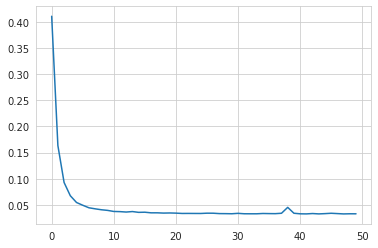

In [21]:
plot_loss(training_losses)

In [22]:
prediction = pd.read_csv('output/sp500_prices_adjclose_30_09_16_30_09_21/train/predict.csv',header=None)
target = pd.read_csv('output/sp500_prices_adjclose_30_09_16_30_09_21/train/target.csv',header=None)

In [23]:
print(prediction.shape)
print(target.shape)

(235, 493)
(235, 493)


In [24]:
target_data = pd.read_csv(data_file).set_index('date').iloc[(train_data.shape[0] + 12):((train_data.shape[0] + 12) + prediction.shape[0]),]
prediction.columns = np.array(target_data.columns) + 'pred'
prediction['date'] = target_data.index
prediction = prediction.set_index('date')

(0.0, 550.0)

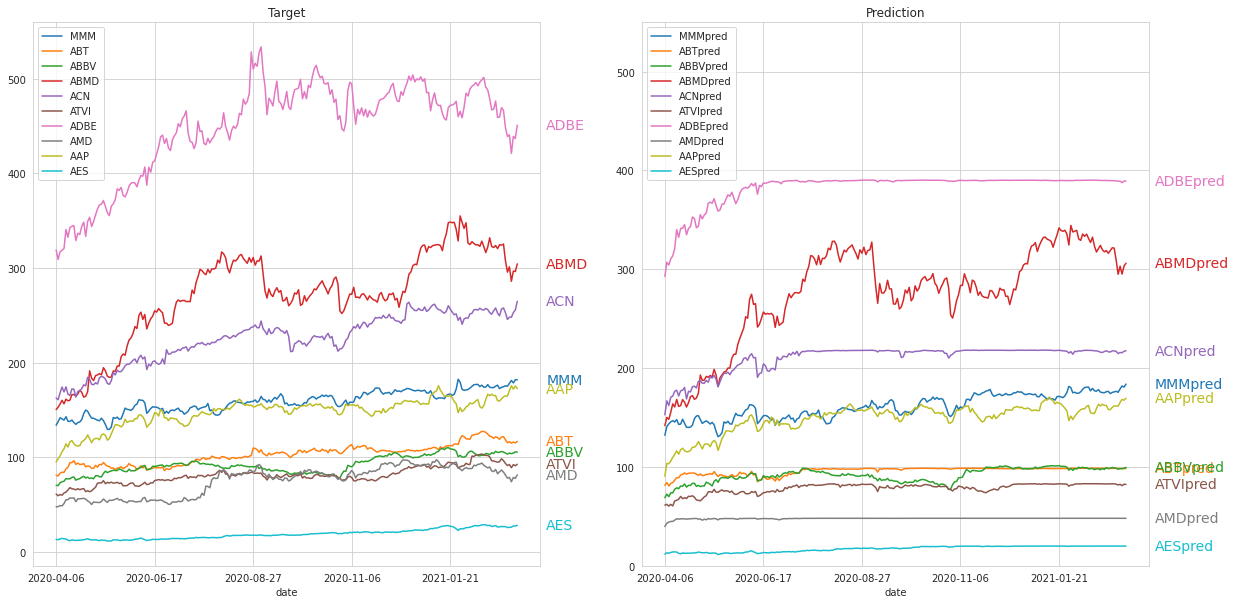

In [25]:

_, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Target')
target_data.iloc[:,:10].plot(ax=ax[0])
for line, name in zip(ax[0].lines, target_data.columns):
    y = line.get_ydata()[-1]
    ax[0].annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax[0].get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")


# _, ax = plt.subplots(figsize=(10,10))
prediction.iloc[:,:10].plot(ax=ax[1])
ax[1].set_title('Prediction')
for line, name in zip(ax[1].lines, prediction.columns):
    y = line.get_ydata()[-1]
    ax[1].annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax[1].get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
ax[1].set_ylim(0,550)

In [26]:
# partition dataset into the three clusters provided by Suhwan
# path of the clusters csv is /content/drive/MyDrive/Nanyang/class/CE7454/cluster.csv

clusters_partition = pd.read_csv("/content/drive/MyDrive/Nanyang/class/CE7454/cluster.csv")
clusters = range(1, 5)
clusters_partition.head()

,ts1,cluster
0,A,1
1,AAL,2
2,AAP,1
3,AAPL,1
4,ABBV,1


In [27]:
full_data = pd.read_csv(data_file).drop('date',1)
result_train_files = []
result_test_files = []

for cluster in clusters:
    result_train_file = os.path.join('output', str(cluster), 'train')
    result_test_file = os.path.join('output', str(cluster), 'test')
    if not os.path.exists(result_train_file):
        os.makedirs(result_train_file)
    if not os.path.exists(result_test_file):
        os.makedirs(result_test_file)
    result_train_files.append(result_train_file)
    result_test_files.append(result_test_file)


In [28]:
# 400 in cluster 1, 20 in cluster 2, 71 in cluster 3
train_data = []
valid_data = []
test_data = []

for cluster in clusters:
    print("Cluster", cluster)
    selected_stocks = clusters_partition.loc[:, 'ts1'][clusters_partition["cluster"] == cluster]
    print(selected_stocks.tolist())
    cluster_data = full_data[selected_stocks].values
    train_data.append(cluster_data[:int(train_ratio * len(data))])
    valid_data.append(cluster_data[int(train_ratio * len(data)):int((train_ratio + valid_ratio) * len(data))])
    test_data.append(cluster_data[int((train_ratio + valid_ratio) * len(data)):])

Cluster 1
['A', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BAC', 'BAX', 'BBY', 'BDX', 'BIO', 'BK', 'BKNG', 'BLK', 'BLL', 'BMY', 'BR', 'BSX', 'BWA', 'C', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTXS', 'CVX', 'CZR', 'D', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DPZ', 'DRE', 'DRI', 'DTE', 'DUK', 'DVA', 'DXCM', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EL', 'EMN', 'EMR', 'ENPH', 'EQIX', 'EQR', 'ES', 'ESS', 'ETN', 'ETR', 'ETSY', '

In [29]:
debug_corr_1_list = []
debug_corr_2_list = []
debug_corr_3_list = []
debug_corr_4_list = []

training_loss_list = []
best_performance_list = []

for cluster in clusters:
    before_train = datetime.now().timestamp()
    _, normalize_statistic, training_loss, best_performance = train(train_data[cluster-1], valid_data[cluster-1], args, result_train_files[cluster-1])
    after_train = datetime.now().timestamp()
    print(f'Training took {(after_train - before_train) / 60} minutes')

    debug_corr_1_list.append(np.array(debug_corr_1))
    debug_corr_2_list.append(np.array(debug_corr_2))
    debug_corr_3_list.append(np.array(debug_corr_3))
    debug_corr_4_list.append(np.array(debug_corr_4))

    training_loss_list.append(training_loss)
    best_performance_list.append(best_performance)

    debug_step = 0
    debug_corr_1 = None
    debug_corr_2 = None
    debug_corr_3 = None
    debug_corr_4 = None

Total Trainable Params: 1077463
| end of epoch   0 | time:  5.40s | train_total_loss 0.4196
------ validate on data: VALIDATE ------
NORM: MAPE 97.010723848%; MAE 1.593713068; RMSE 2.342594517.
RAW : MAPE 19.438831631%; MAE 38.844970325; RMSE 97.860540000.
| end of epoch   1 | time:  5.29s | train_total_loss 0.1441
------ validate on data: VALIDATE ------
NORM: MAPE 109.146729959%; MAE 1.538866085; RMSE 2.255297742.
RAW : MAPE 19.325022074%; MAE 34.734584068; RMSE 85.789360729.
| end of epoch   2 | time:  5.26s | train_total_loss 0.0825
------ validate on data: VALIDATE ------
NORM: MAPE 84.386809758%; MAE 1.270867214; RMSE 2.031288508.
RAW : MAPE 15.288377373%; MAE 29.655699467; RMSE 77.557935079.
| end of epoch   3 | time:  5.34s | train_total_loss 0.0632
------ validate on data: VALIDATE ------
NORM: MAPE 68.923496003%; MAE 1.142296466; RMSE 1.939789857.
RAW : MAPE 13.385799767%; MAE 27.261335071; RMSE 73.478308980.
| end of epoch   4 | time:  5.35s | train_total_loss 0.0551
------ 

In [30]:
def visualize_results(cluster):
    prediction = pd.read_csv(f'output/{cluster}/train/predict.csv',header=None)
    target = pd.read_csv(f'output/{cluster}/train/target.csv',header=None)
    selected_stocks = clusters_partition.loc[:, 'ts1'][clusters_partition["cluster"] == cluster]
    indexes = selected_stocks.tolist()
    indexes.append('date')
    target_data = pd.read_csv(data_file)[indexes].set_index('date').iloc[(train_data[cluster-1].shape[0] + 12):((train_data[cluster-1].shape[0] + 12) + prediction.shape[0]),]
    prediction.columns = np.array(target_data.columns) + 'pred'
    prediction['date'] = target_data.index
    prediction = prediction.set_index('date')
    _, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].set_title('Target')
    target_data.iloc[:,:10].plot(ax=ax[0])
    for line, name in zip(ax[0].lines, target_data.columns):
        y = line.get_ydata()[-1]
        ax[0].annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                    xycoords = ax[0].get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center")


    # _, ax = plt.subplots(figsize=(10,10))
    prediction.iloc[:,:10].plot(ax=ax[1])
    ax[1].set_title('Prediction')
    for line, name in zip(ax[1].lines, prediction.columns):
        y = line.get_ydata()[-1]
        ax[1].annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                    xycoords = ax[1].get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center")
    ax[1].set_ylim(0,550)

In [31]:
import numpy as np
import scipy
from matplotlib import pyplot as plt


def visualize_map(cluster):
    def normalize_plot(mat):
        return scipy.stats.zscore(mat, axis=None)

    figure = plt.figure(figsize=(8, 8))
    plt.subplot(221)
    plt.title('self_graph_attention() before leakyrelu')
    plt.imshow(normalize_plot(debug_corr_1_list[cluster-1][0]))

    plt.subplot(222)
    plt.title('plus leakyrelu')
    plt.imshow(normalize_plot(debug_corr_2_list[cluster-1][0]))

    plt.subplot(223)
    plt.title('plus softmax(dim=-1) and mean(dim=0)')
    plt.imshow(normalize_plot(debug_corr_3_list[cluster-1]))

    plt.subplot(224)
    plt.title('plus (attention + attention.T)')
    plt.imshow(normalize_plot(debug_corr_4_list[cluster-1]))


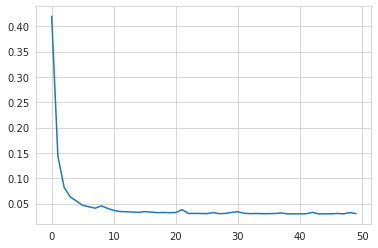

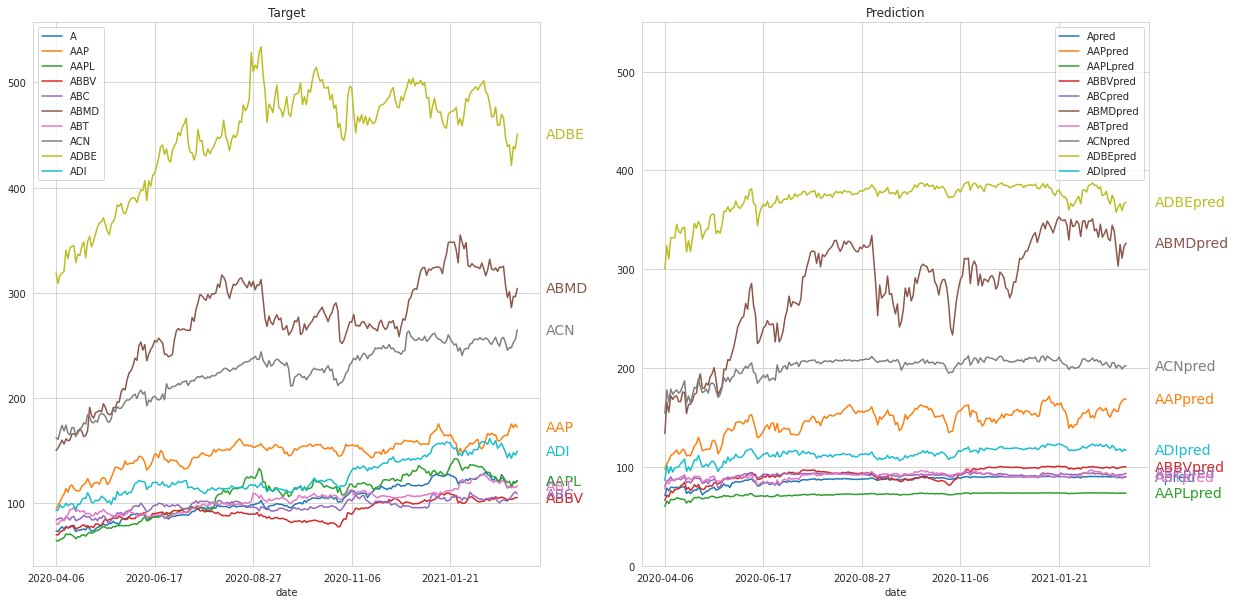

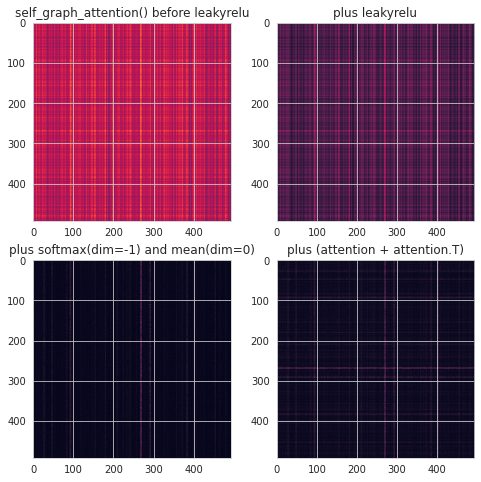

In [32]:
'''
400 stocks
NORM: MAPE 59.159800219%; MAE 1.256706933; RMSE 2.151056427.
RAW : MAPE 13.870056164%; MAE 31.471025260; RMSE 84.599123367.
Training took 2.4937577486038207 minutes
'''
plot_loss(training_loss_list[0])
visualize_results(cluster=1)
visualize_map(cluster=1)

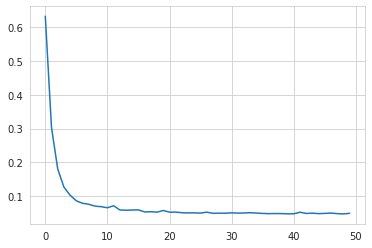

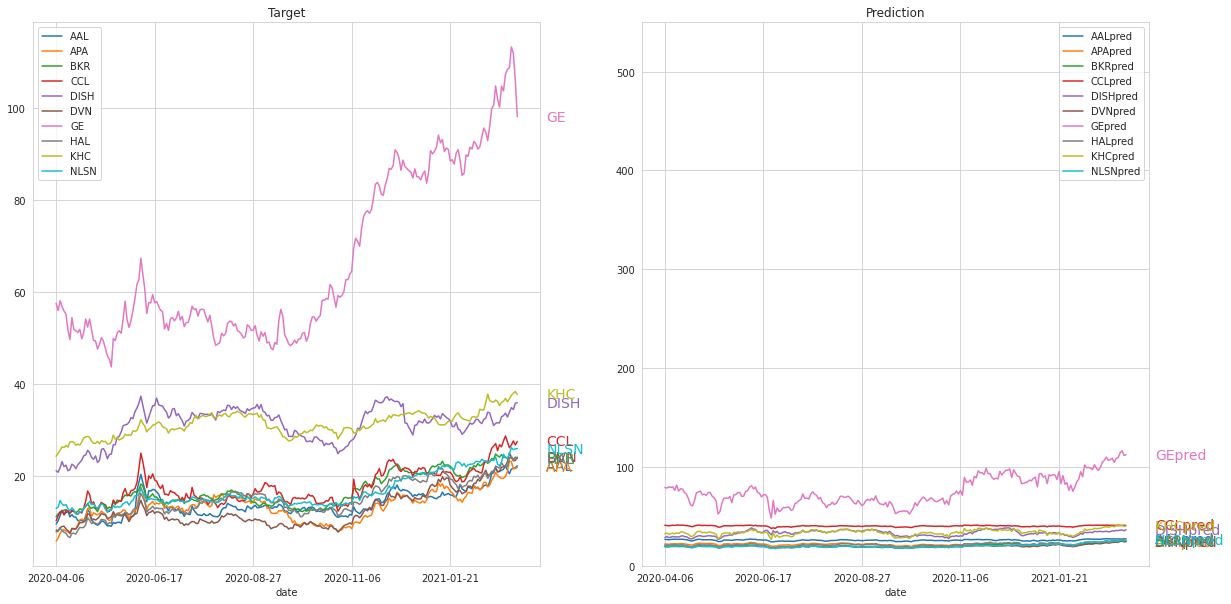

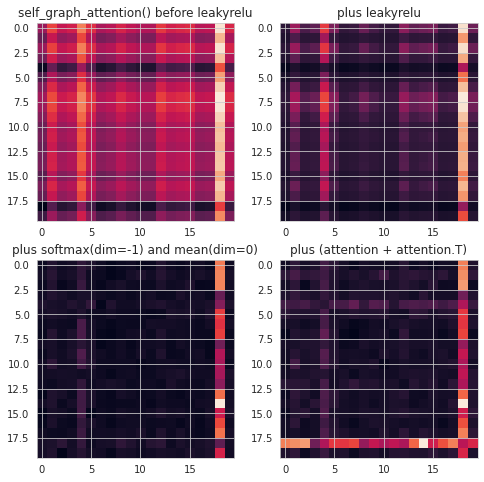

In [33]:
'''
20 stocks
NORM: MAPE 76.330897867%; MAE 1.508740934; RMSE 1.804532450.
RAW : MAPE 77.525642904%; MAE 15.531246071; RMSE 18.198214374.
Training took 0.6056053519248963 minutes
'''
plot_loss(training_loss_list[1])
visualize_results(cluster=2)
visualize_map(cluster=2)

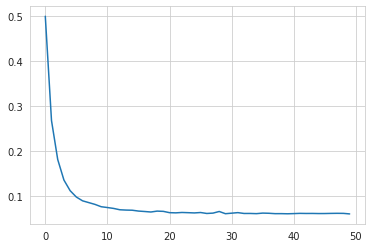

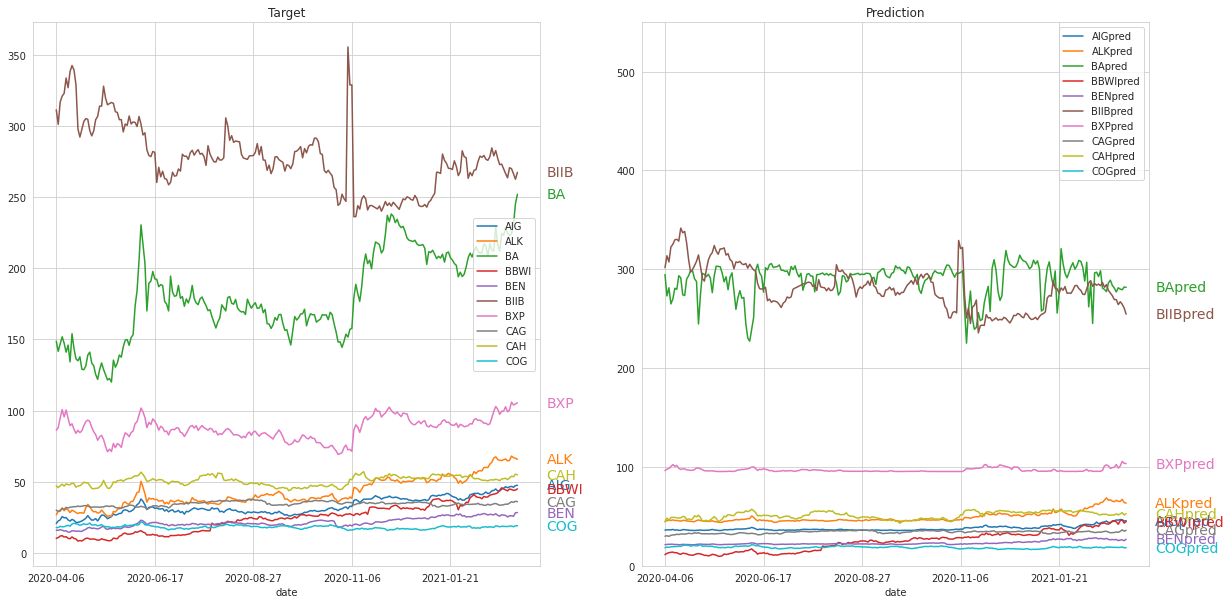

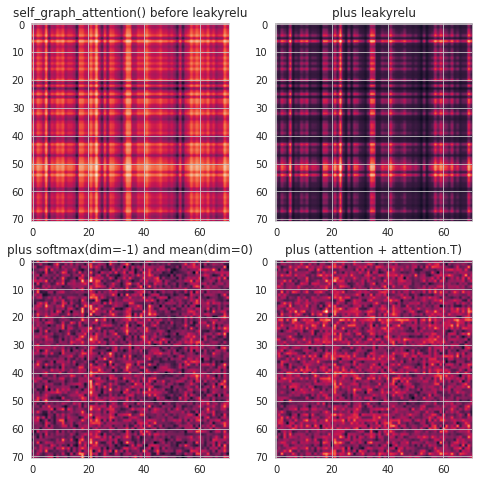

In [34]:
'''
71 stocks
NORM: MAPE 64.038134969%; MAE 0.865533014; RMSE 1.260219140.
RAW : MAPE 20.049844685%; MAE 8.501538595; RMSE 14.978990272.
Training took 0.7090381344159444 minutes
'''
plot_loss(training_loss_list[2])
visualize_results(cluster=3)
visualize_map(cluster=3)

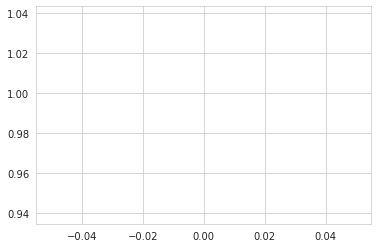

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
posx and posy should be finite values
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: Use

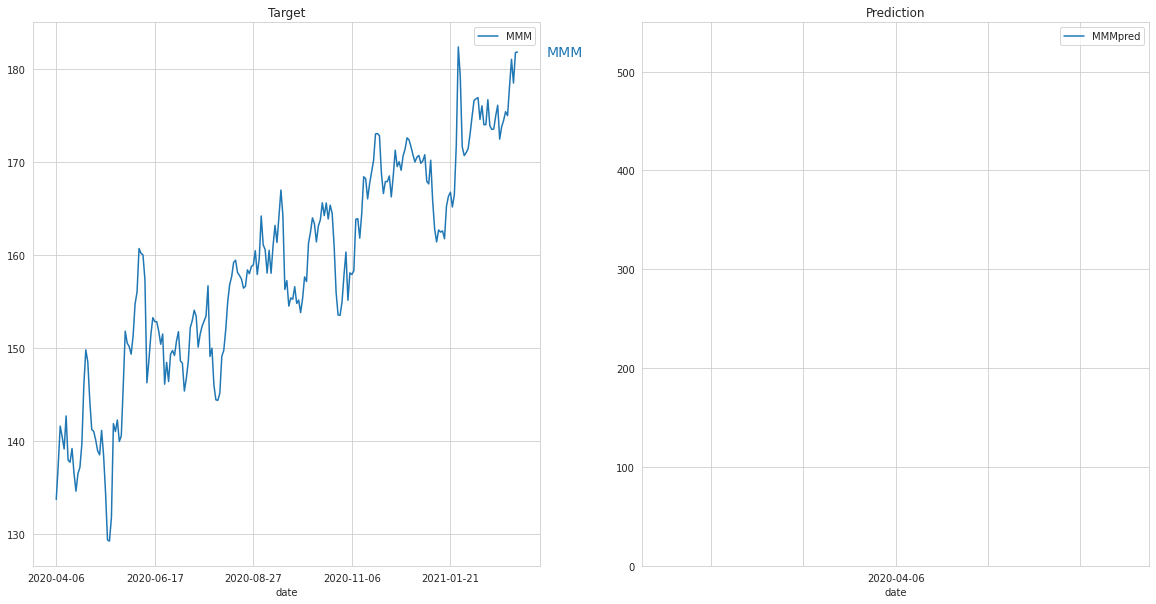

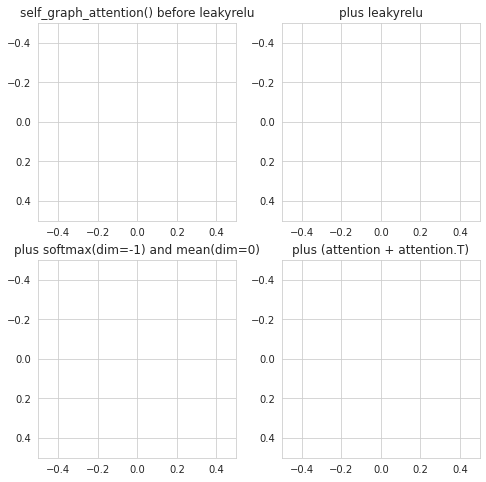

In [35]:
'1 stock'
plot_loss(training_loss_list[3])
visualize_results(cluster=4)
visualize_map(cluster=4)

In [36]:
# aggregate best_performance_list
#print(best_performance_list)

def aggregate(metric, number_of_stocks, total_stocks, best_performance_list):
    #print(best_performance_list)
    performance = [c[metric] if c is not None else 0 for c in best_performance_list ]
    print(metric, performance)
    return np.dot(performance, number_of_stocks) / total_stocks

metrics = ['mae', 'mape', 'rmse']

number_of_stocks = [x.shape[1] for x in train_data]
total_stocks = np.sum(number_of_stocks)

for metric in metrics:
    print(metric)
    aggregated_metric = aggregate(metric, number_of_stocks, total_stocks, best_performance_list)
    aggregated_metric_norm = aggregate(metric + "_norm", number_of_stocks, total_stocks, best_performance_list)
    print("Metric", metric, aggregated_metric)
    print("Metric", metric + "_norm", aggregated_metric_norm)

mae
mae [20.455968848064803, 8.2696490845437, 6.269882611470258, 16.384388113379323]
mae_norm [0.8669956896598869, 1.019986703574281, 0.6099117595116346, 0.8251886399416584]
Metric mae 17.905135313911718
Metric mae_norm 0.8360303526437156
mape
mape [0.09699687091178277, 0.4531468863484313, 0.1425067472442461, 0.109039251682882]
mape_norm [0.47033214759644226, 0.3609342851573572, 0.4098086469764155, 1.0043170451529473]
Metric mape 0.11806647235306116
Metric mape_norm 0.4582363327687043
rmse
rmse [59.406519969022696, 10.65019132065516, 15.678382087860582, 19.75519376986542]
rmse_norm [1.7053703320252664, 1.4987349941332717, 1.0261824425477504, 0.9949569899059773]
Metric rmse 51.0336019025003
Metric rmse_norm 1.5975137054950574
